# Importing Modules

In [1]:
# Data wrangling libraries
import pandas as pd
import numpy as np
import cudf # GPU version of pandas
from numba import cuda
import os
import multiprocessing as mp

# ML Libraries
from cuml import KMeans # GPU version of scikit-learn

# Plotting libraries
import datashader as ds
import datashader.transfer_functions as tf

# wrapper functions
from resultHelperClass import Result
from open_source_algo.cvxEDA import wrapperCVXEDA

# Scary Movie Data

In [2]:
scary_movie_session_gpu = cudf.read_csv("resources/csv/default_exp_Session1_Shimmer_92E8_Calibrated_PC_Session2.csv", delimiter="\t", header=1)

In [3]:
scary_movie_session_gpu.drop(columns=scary_movie_session_gpu.columns[-1], axis=1, inplace=True)

In [4]:
scary_movie_session_gpu.drop(index=0, axis=0, inplace=True)
scary_movie_session_gpu.reset_index(drop=True, inplace=True)

In [5]:
scary_movie_session_gpu = scary_movie_session_gpu.astype("float64")

In [6]:
value = scary_movie_session_gpu.loc[0, scary_movie_session_gpu.columns[0]]

In [7]:
def normalized_cudf(e):
    return e - value

In [8]:
scary_movie_session_gpu[scary_movie_session_gpu.columns[0]] = scary_movie_session_gpu[scary_movie_session_gpu.columns[0]].apply(normalized_cudf)

In [9]:
%%capture
Fs = 150  # the frequency of the shimmer gsr+
processor = 1
pool = mp.Pool(mp.cpu_count())
result = Result()
# slow convex optimization for Electro-dermal activity (cvxEDA)
pool.apply_async(wrapperCVXEDA, [scary_movie_session_gpu.Shimmer_92E8_GSR_Skin_Conductance_CAL.to_numpy(), 1 / Fs], callback=result.update_value)

In [10]:
cvs = ds.Canvas(plot_height=650, plot_width=2000)

In [11]:
agg = cvs.line(source=scary_movie_session_gpu, x=scary_movie_session_gpu.columns[0], y=scary_movie_session_gpu.columns[1], agg=ds.mean(scary_movie_session_gpu.columns[1]))

/home/hb/.conda/envs/rapids-23.02/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


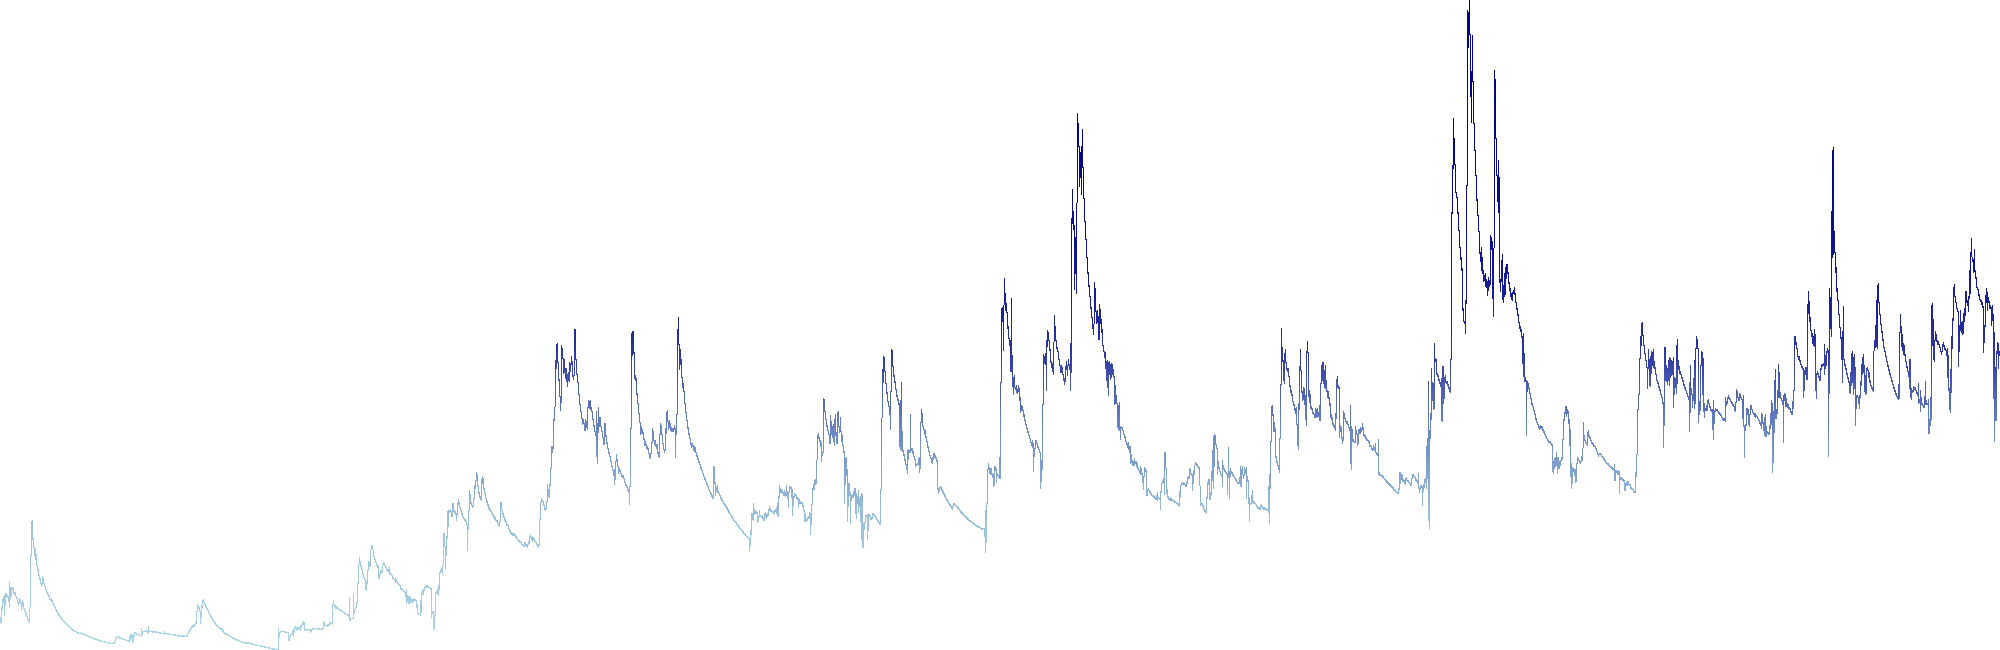

In [13]:
tf.shade(agg)

In [14]:
res = []

In [15]:
if result.is_done():
    """
        r: phasic component
        p: sparse SMNA driver of phasic component
        t: tonic component
        l: coefficients of tonic spline
        d: offset and slope of the linear drift term
        e: model residuals
        obj: value of objective function being minimized (eq 15 of paper)
    """
    res = result.get_value()
else:
    print("Not yet!")

Not yet!


In [ ]:
wrapperCVXEDA(scary_movie_session_gpu.loc[:100000, scary_movie_session_gpu.columns[1]].to_numpy(), 1/Fs)

In [ ]:
scary_movie_session_gpu["phasic"] = res[0]

In [ ]:
kmeans = KMeans(n_clusters=2, n_init="auto")

In [ ]:
scary_movie_session_gpu["label"] = kmeans.fit_predict(scary_movie_session_gpu[["phasic"]])

In [ ]:
scary_movie_session_gpu.label = scary_movie_session_gpu.label.apply(bool)